# 2 layer synthetic inversion, with a regional field

Here we try to recover the true Layer 2 topography with a gravity inversion. The gravity data is the forward gravity of Layer 1, 2, and 3, representing a perfect gravity survey with no error. The inputs into the inversion are a full resolution Layer 1, representing the `ice surface`, a low resolution Layer 2, representing the `bed topography`, which has been created through the random sampling and grid of 30 contraint points. In an Antarctic setting, these points represent single seismic survey locations which image the elevation of Layer 2. While not included as a layer in the inversion, the forward gravity of Layer3 is included in the observed gravity. This field represents the regional gravity signal from factors such as long wavelength crustal thickness variations. 

import packages

In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

from RIS_gravity_inversion import regional, synthetic, plotting, optimization, synthetic
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings

import os

# Load data

## topographic layers
* 3 full resolution synthetic layers
* low resolution layer 2

In [ ]:
layer1 = xr.open_zarr("../synthetic_data/synthetic_layer1.zarr").z

layer2 = xr.open_zarr("../synthetic_data/synthetic_layer2.zarr").z

lowres_layer2 = xr.open_zarr("../synthetic_data/synthetic_lowres_layer2.zarr").z

layer3 = xr.open_zarr("../synthetic_data/synthetic_layer3.zarr").z

# ensure all xarray are same data type
layer1 = layer1.astype(np.float64)
layer2 = layer2.astype(np.float64)
lowres_layer2 = lowres_layer2.astype(np.float64)
layer3 = layer3.astype(np.float64)

print(utils.get_grid_info(layer1))
print(utils.get_grid_info(layer2))
print(utils.get_grid_info(lowres_layer2))
lowres_layer2

## gravity data
* full resolution gravity grid
* gravity observations

In [ ]:
# full resolution gravity point data
full_res_grav = pd.read_csv(
    "../synthetic_data/synthetic_2layer_with_regional_full_res_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# sampled gravity point data
sampled_grav = pd.read_csv(
    "../synthetic_data/synthetic_2layer_with_regional_sampled_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# Set region and parameters

Use the same regions and parameters as `synthetic_model_simple_with_regional.ipynb`

In [ ]:
layer_spacing, inversion_region, _, _, registration = utils.get_grid_info(layer2)

# set gravity observation parameters
grav_observation_height = 1e3
sampled_grav_spacing = 2e3

buffer_region = utils.alter_region(
    inversion_region,
    buffer=0,
)[1]

# set densities
air_density = 1
ice_density = 917
sediment_density = 2300

print(f"spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

### prep grav data

In [ ]:
full_res_grav = inv_utils.prep_grav_data(
    full_res_grav,
    region=inversion_region,
    input_grav_name="forward_total",
    input_coord_names=("easting", "northing", "upward"),
)

sampled_grav = inv_utils.prep_grav_data(
    sampled_grav,
    region=inversion_region,
    input_grav_name="Gobs",
    input_coord_names=("easting", "northing", "upward"),
)

print(f"full resolution gravity: {len(full_res_grav)} points")
print(f"sampled gravity: {len(sampled_grav)} points")

print(f"gravity avg. elevation: {int(np.nanmean(full_res_grav.upward))}")

## constraint points

In [ ]:
# load constraint points into a dataframe
constraint_points_all = pd.read_csv(
    "../synthetic_data/synthetic_constraints.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within inversion region
constraint_points = utils.points_inside_region(
    constraint_points_all, inversion_region, names=("easting", "northing")
)

print(f"bathymetry control points:{len(constraint_points)}")
constraint_points.head()

## plot inputs

In [ ]:
# grid the observed gravity
Gobs = full_res_grav.set_index(["northing", "easting"]).to_xarray().Gobs

# plot observed gravity
fig = maps.plot_grd(
    grid=Gobs,
    fig_height=8,
    cmap="vik",
    region=buffer_region,
    title="Observed gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

# plot layer 1
fig = maps.plot_grd(
    grid=layer1,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Layer 1",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=lowres_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Low-resolution Layer 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)
fig.text(
    position="TL",
    justify="BL",
    text="c)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

fig.show()

# Bouguer correction

The `observed gravity` includes a gravitational signal from density contrast across Layer 1 (air-ice), Layer 2 (ice-bed), and Layer 3 (regional field). Since we want to invert for Layer 2, we need to remove the component of this gravity from Layer 1 and Layer 3. Here we show how to remove the Layer 1 component, and later will show how to remove the Layer 3 component.

To do this, we build a series of vertical prisms around a flat reference, which we take to be the mean value of Layer 1. The prisms extend above or below this reference, towards Layer 1. Prisms above the reference are assigned a positive density contrast ($\rho_{ice}$ - $\rho_{air}$), while prisms below the reference are assigned a negative density contrast ($\rho_{air}$ - $\rho_{ice}$). This is shown in b) and c) of the below figure.

At each stage of the inversion, the we ensure the updated bed elevation doesn't intersect Layer 1. This means the Layer 1 density contrast will be constant throughout the inversion, and can thus be calculated and accounted for only once, at the beginning. 

Here, we calculate the forward gravity of this density contrast, and remove it from the observed gravity to make a `corrected observed gravity`. 

<img src="../figures/synthetic_model_simple_2layer.svg" width="1000"/>

## Ice prisms

In [ ]:
# create prisms around Layer 1
# positive densities above reference, negative below
density = ice_density - air_density
print(f"Surface density contrast: {density}kgm-3")

layer1_prisms = inv_utils.grids_to_prisms(
    surface=layer1,
    reference=layer1.values.mean(),
    density=xr.where(layer1 >= layer1.values.mean(), density, -density),
)

# plotting.show_prism_layers(
#     [layer1_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

## Ice gravity

In [ ]:
# calculate gravity of layer1
layer1_grav_grid, layer1_grav_df = inv_utils.forward_grav_of_prismlayer(
    [layer1_prisms],
    full_res_grav,
    names=["layer1_prisms"],
    remove_median=False,
    progressbar=True,
    plot=False,
)

full_res_grav["layer1_forward"] = layer1_grav_df.forward_total

# subtract from observed gravity
full_res_grav["Gobs_corr"] = full_res_grav.Gobs - full_res_grav.layer1_forward

# grid the results
layer1_forward = (
    full_res_grav.set_index(["northing", "easting"]).to_xarray().layer1_forward
)
Gobs_corr = full_res_grav.set_index(["northing", "easting"]).to_xarray().Gobs_corr

full_res_grav

In [ ]:
# plot Layer 1 gravity
fig = maps.plot_grd(
    grid=layer1_forward,
    fig_height=8,
    cmap="vik",
    region=buffer_region,
    title="Surface 1 forward gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
# plot corrected gravity
fig = maps.plot_grd(
    grid=Gobs_corr,
    fig_height=8,
    cmap="vik",
    region=buffer_region,
    title="Corrected gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
fig.show()

# Gravity misfit

The `gravity misfit` is defined as the difference between the observed and predicted gravity:

$G_{misfit} = G_{obs} - G_{forward}$ 

To determine $G_{misfit}$, we need to forward model the gravitational effect of the low-resolution Layer 2 density contrast. This will be the input into our inversion.


## Bed prisms

In [10]:
# create prisms around low-res Layer 2
# positive densities above reference, negative below
density = sediment_density - ice_density
print(f"Bed density contrast: {density}kgm-3")

layer2_prisms = inv_utils.grids_to_prisms(
    surface=lowres_layer2,
    reference=lowres_layer2.values.mean(),
    density=xr.where(lowres_layer2 >= lowres_layer2.values.mean(), density, -density),
)

# plotting.show_prism_layers(
#     [layer2_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

Bed density contrast: 1383kgm-3


## bed gravity

In [11]:
# calculate gravity of layer1
layer2_grav_grid, layer2_grav_df = inv_utils.forward_grav_of_prismlayer(
    [layer2_prisms],
    full_res_grav,
    names=["layer2_prisms"],
    remove_median=False,
    progressbar=True,
    plot=False,
)

full_res_grav["layer2_forward"] = layer2_grav_df.forward_total

# grid the results
layer2_forward = (
    full_res_grav.set_index(["northing", "easting"]).to_xarray().layer2_forward
)

full_res_grav

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,Surface1,Surface2,Surface3,Gobs,upward,layer1_forward,Gobs_corr,layer2_forward
0,0.0,0.0,5.504590,2.609273,-0.700915,978039.412948,1000.0,5.498587,978033.914361,2.446020
1,0.0,1000.0,6.836422,3.247036,-0.768264,978041.315194,1000.0,6.828967,978034.486227,3.022590
2,0.0,2000.0,7.194027,3.510906,-0.845146,978041.859787,1000.0,7.186182,978034.673605,3.231865
3,0.0,3000.0,7.201964,3.583988,-0.930920,978041.855032,1000.0,7.194110,978034.660922,3.259478
4,0.0,4000.0,7.070751,3.566158,-1.023902,978041.613007,1000.0,7.063040,978034.549967,3.204419
...,...,...,...,...,...,...,...,...,...,...
4936,60000.0,76000.0,-0.555972,1.111909,6.023106,978038.579044,1000.0,-0.555365,978039.134409,1.708346
4937,60000.0,77000.0,-0.469248,1.090120,5.694928,978038.315800,1000.0,-0.468736,978038.784536,1.702398
4938,60000.0,78000.0,-0.380042,1.044688,5.291988,978037.956634,1000.0,-0.379628,978038.336262,1.659675
4939,60000.0,79000.0,-0.292920,0.945389,4.815383,978037.467853,1000.0,-0.292600,978037.760453,1.526755


## Misfit

In [12]:
full_res_grav = inv.misfit(
    input_grav=full_res_grav,
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr",
    constraints=constraint_points,
)

DC shifted observed gravity by 978030.21mGal to match forward gravity.


gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


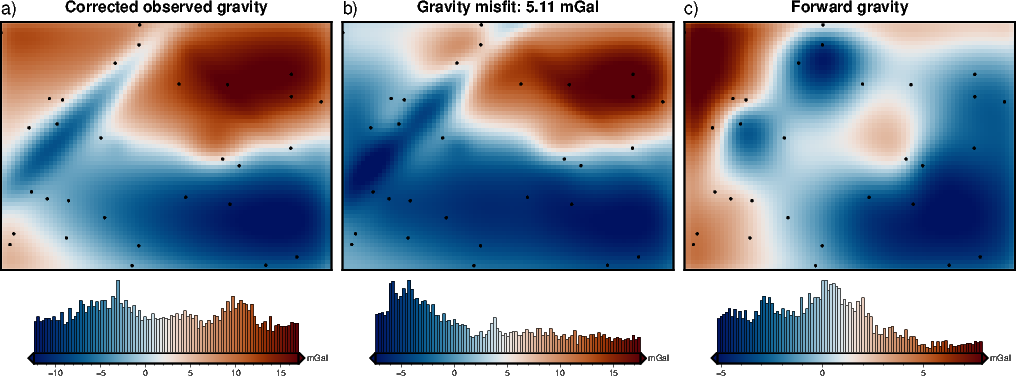

In [13]:
plotting.misfit_plotting(
    full_res_grav,
    grav_spacing=layer_spacing,
    plot_type="pygmt",
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr_shift",
    constraints=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)

## Regional - Residual seperation

The `corrected observed gravity` is the combination of the signal from the density contrasts of `Surface 2` and `Surface 3`. Both of these signals contain long-wavelength components, since both surface have long-wavelength topographic features. The `Surface 2` signal also contains short-wavelength components. Deeper in the crust, further away from the gravity observation points, these short-wavelength components decrease in amplitude. This means the majority the short-wavelength signal in the `corrected observed gravity` is resulting from the density contrast of `Surface 2`. This is the signal we want to isolate and input into the inversion. 

To do this, we need to seperate the gravity misfit into a `regional` component and a `residual` component. This `regional` field should theoretically contain every gravity signal other than the that resulting from the `Surface 2` surface. Additionaly, this `residual` component should theoretically represent the gravity anomaly due to the difference between the true `Surface 2` and the low-resolution `Surface 2`. 

If we fail to accurately remove the `regional` signal, the resulting `Surface 2` surface after the inversion will contain long-wavelength topography, resulting from the `regional` gravity field. 

Since we create the synthetic model, we precisely know the regional component (the forward gravity of `Surface 3`), and can thus tune our regional-residual seperation method to accurately remove the regional field. 

In [ ]:
# load the true regional gravity anomaly
true_layer3_grav = fetch.resample_grid(
    synthetic_gravity.Layer3,
    region=inversion_region,
    spacing=grav_spacing,
    registration=registration,
)

### optimize the regional-residual seperation

We have 4 methods to seperate the regional misfit from the residual misfit.
1) `Filter` method: Apply a low-pass filter to the misfit
2) `Trend` method: Fit a trend to the misfit
3) `Constraints` method: Sample and grid the misfit only at constraint points, where we know the true layer depth
4) `Equivalent-Sources` method: Predict the gravity anomaly resulting from a serious of deep sources.

Each of these methods has 1 parameter to tune. Respectively, these are 
1) gaussian low-pass filter width (1km - 1000km)
2) trend order (1 - 20)
3) gridding tension factor (0 - 1)
4) source depth (10km - 10,000km)

The optimization will explore the parameter space of each of these, and return the parameters which result in your choice of:
a) a `regional misfit` closest to the true layer 3 forward gravity,
b) the smallest `residuals` at the constraint points

Since we know the true `regional` field, we will use method a). For a true inversion where you don't know the `regional` field, you can use method b). This method finds the seperation method which minimize the `residuals` at contraint points. Since at these contraint points you know the starting layer elevation is accurate, the misfit should be entirely due to the `regional` field, and the `residual` should be close to 0. 

Choose to either run all 4 methods in the same optimization, or run each seperately. 

In [ ]:
regional_kwargs = dict(
    input_grav=grav,
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr",
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    true_regional=true_layer3_grav,
    constraints=constraint_points,
)

#### Optimize 4 methods together

In [ ]:
# # set comparison_method
# comparison_method='minimize_constraints'
# # comparison_method='regional_comparison'

# # set name and storage for the optimization
# study_name = f"regional_seperation_together_{comparison_method}"
# storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# # set number of runs
# n_trials=100

# # create a new study
# study = optuna.create_study(
#     study_name=study_name,
#     storage=storage,
#     direction="minimize",
#     sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#     load_if_exists=True,
#     )

# # define objective function
# objective = optimization.optimal_regional_params(
#         comparison_method = comparison_method,
#         regional_method_options = [
#             "filter",
#             "trend",
#             "constraints",
#             "eq_sources",
#         ],
#         filter_limits = [10e3, 1000e3, 10e3], # 100 options
#         trend_limits = [1, 20, 1], # 20 options
#         constraints_limits = [0, 1, 0.01], # 101 options
#         eq_sources_limits = [10e3, 10000e3, 10e3], # 1000 options
#         **regional_kwargs)

# # run the optimization
# with inv_utils.HiddenPrints():
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         study, study_df = optimization.optuna_parallel(
#             study_name=study_name,
#             study_storage=storage,
#             objective = objective,
#             n_trials=n_trials,
#             maximize_cpus=True,
#         )

# optuna.visualization.plot_optimization_history(study).show()
# optuna.visualization.plot_slice(study).show()

# plotting.plot_best_param(study_df, comparison_method, **regional_kwargs)

#### Optimize methods individually

In [ ]:
# # set comparison method
# comparison_method='minimize_constraints'
# # comparison_method='regional_comparison'

# # set regional method
# # regional_method = "filter"
# regional_method = "trend"
# # regional_method = "constraints"
# # regional_method = "eq_sources"

# # set name and storage for the optimization
# study_name = f"regional_seperation_{regional_method}_{comparison_method}"
# storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# # set number of runs
# n_trials=50

# # create a new study
# study = optuna.create_study(
#     study_name=study_name,
#     storage=storage,
#     direction="minimize",
#     sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#     load_if_exists=True,
#     )

# # define the objective function
# objective = optimization.optimal_regional_params(
#     comparison_method = comparison_method,
#     regional_method = regional_method,
#     filter_limits = [10e3, 1000e3, 10e3], # 100 options
#     trend_limits = [1, 20, 1], # 20 options
#     constraints_limits = [0, 1, 0.01], # 101 options
#     eq_sources_limits = [10e3, 10000e3, 10e3], # 1000 options
#     **regional_kwargs)

# # run the optimization
# with inv_utils.HiddenPrints():
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         study, study_df = optimization.optuna_parallel(
#             study_name=study_name,
#             study_storage=storage,
#             objective=objective,
#             n_trials=n_trials,
#             maximize_cpus=True,
#         )

# optuna.visualization.plot_optimization_history(study).show()
# optuna.visualization.plot_slice(study).show()

# plotting.plot_best_param(study_df, comparison_method, regional_method=regional_method, **regional_kwargs)

## Optimize all methods individually

In [ ]:
# set comparison method
# comparison_method='minimize_constraints'
comparison_method = "regional_comparison"

methods = ["filter", "trend", "constraints", "eq_sources"]

# for i in methods:
#     # set name and storage for the optimization
#     study_name = f"regional_seperation_indiv_{i}_{comparison_method}"
#     storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

#     # set number of runs
#     n_trials=50

#     # create a new study
#     study = optuna.create_study(
#         study_name=study_name,
#         storage=storage,
#         direction="minimize",
#         sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#         load_if_exists=True,
#         )

#     # define the objective function
#     objective = optimization.optimal_regional_params(
#         comparison_method = comparison_method,
#         regional_method = i,
#         filter_limits = [10e3, 1000e3, 10e3], # 100 options
#         trend_limits = [1, 20, 1], # 20 options
#         constraints_limits = [0, 1, 0.01], # 101 options
#         eq_sources_limits = [10e3, 10000e3, 10e3], # 1000 options
#         **regional_kwargs)

#     # run the optimization
#     with inv_utils.HiddenPrints():
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             study, study_df = optimization.optuna_parallel(
#                 study_name=study_name,
#                 study_storage=storage,
#                 objective=objective,
#                 n_trials=n_trials,
#                 maximize_cpus=True,
#             )

# load studies
study_dfs = []
for i in methods:
    study_name = f"regional_seperation_indiv_{i}_{comparison_method}"
    storage = JournalStorage(
        JournalFileStorage(f"../optimization_logs/{study_name}.log")
    )
    study = optuna.load_study(storage=storage, study_name=study_name)
    study_df = study.trials_dataframe()
    study_dfs.append(study_df)

    # plot results
    plotting.plot_best_param(
        study_df, comparison_method, regional_method=i, **regional_kwargs
    )
    optuna.visualization.plot_slice(study).show()

studies = dict(zip(methods, study_dfs))

for k, v in studies.items():
    v["params_method"] = k

regional_sep_combined_studies = pd.concat(
    studies.values(), ignore_index=True
).sort_values(by="value")

In [ ]:
df = regional_sep_combined_studies
df.head()

In [ ]:
best_filter = df[df.params_method == "filter"].iloc[0].number
best_trend = df[df.params_method == "trend"].iloc[0].number
best_constraints = df[df.params_method == "constraints"].iloc[0].number
best_eq_sources = df[df.params_method == "eq_sources"].iloc[0].number

print(f"best trial w/ solver = verde: index {best_filter}")
print(f"best trial w/ solver = scipy: index {best_trend}")
print(f"best trial w/ deriv = prisms: index {best_constraints}")
print(f"best trial w/ deriv = annulus: index {best_eq_sources}")

## Best regional seperation

In [ ]:
# choose the regional method:
# regional_method = "filter"
# regional_method = "trend"
regional_method = "constraints"
# regional_method = "eq_sources"

# set the parameter:
# contraints: 1 results in pedastals, 0 is good,
# param = .25

# or use the best parameter from the optimization
param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
    f"params_{regional_method}"
]

df_anomalies = regional.regional_seperation(
    input_grav=grav,
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr",
    grav_spacing=grav_spacing,
    regional_method=regional_method,
    inversion_region=inversion_region,
    filter=f"g{param}",
    trend=param,
    fill_method="pygmt",
    constraints=constraint_points,
    tension_factor=param,
    eq_sources=param,
    depth_type="relative",
    eq_damping=None,
    block_size=grav_spacing,
)

anom_grids = plotting.anomalies_plotting(
    df_anomalies,
    region=inversion_region,
    grav_spacing=grav_spacing,
    title=f" Method: {regional_method}, parameter: {param}",
    # constraints=constraint_points,
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr",
)

# Plot Inputs

In [ ]:
# grid the residual misfit
residual = pygmt.surface(
    data=df_anomalies[["x", "y", "res"]],
    region=inversion_region,
    spacing=grav_spacing,
    T=0.25,
    # M="0c",
    registration=registration,
)

In [ ]:
# plot residual misfit
fig = maps.plot_grd(
    grid=residual,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Residual Misfit",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=starting_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Starting Surface 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

fig.show()

# Inversion

Now that we have $G_{misfit}$, we can run an inversion to attempt to recover the true Layer 2 topography. 

To determine optimal inversion parameters, we will run an optimization routine which minimizes the root median square error (RMSE) of the ending Surface 2 to the true Surface 2. 

The parameters we will test are:
* Jacobian methods (annulus vs small prisms)
* Solver methods (Scipy lsqr vs Verde lsqr)
* Solver damping
* max prism change per iteration

In [ ]:
# prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
#     input_grav=df_anomalies,
#     input_grav_column = 'Gobs_corr',
#     prism_layer=layer2_prisms,

#     max_iterations=3,

#     # optional
#     l2_norm_tolerance=.2,
#     delta_l2_norm_tolerance=.8, #1.001,

#     # Jacobian options
#     # deriv_type = "annulus",
#     deriv_type = "prisms",
#     # jacobian_prism_size = 1, # doesn't seem to make a difference

#     # Solver options
#     # Damping: scipy least squares and verde least squares
#     # Weighting: verde least squares
#     solver_type = "verde least squares",
#     solver_damping = 1e4,

#     # solver_type = "scipy least squares",
#     # solver_damping = .01,
# )

In [ ]:
# grids = plotting.plot_inversion_results(
#     grav_results,
#     prism_results,
#     params,
#     grav_region=inversion_region,
#     grav_spacing=grav_spacing,
#     constraints=constraint_points,
#     plot_topo_results=False,
#     plot_grav_results=False,
#     iters_to_plot=4,
#     )

## Optimization

In [ ]:
# set kwargs for inversion
no_noise_kwargs = dict(
    input_grav=df_anomalies,
    input_grav_column="Gobs_corr",
    prism_layer=layer2_prisms,
    max_iterations=50,
    l2_norm_tolerance=0.2,
    delta_l2_norm_tolerance=0.8,
)

In [ ]:
# set name and storage for the optimization
study_name = "2layer_inversion_with_regional_params"
storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# set number of runs
n_trials = 100

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# # create study
# study = optuna.create_study(
#     study_name=study_name,
#     storage=storage,
#     directions=directions,
#     # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#     sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#     load_if_exists=True,
#     )

# # define the objective function
# objective_func = optimization.optimal_inversion_params(
#     true_layer2,
#     verde_damping_limits = [0, 1e4],
#     scipy_damping_limits = [0, 1],
#     objectives = objectives,
#     constraints = constraint_points,
#     **no_noise_kwargs)

# # run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = optimization.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#     )

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)

plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

In [ ]:
start = study.trials_dataframe().sort_values(by="datetime_start").iloc[0].datetime_start
stop = (
    study.trials_dataframe()
    .sort_values(by="datetime_complete", ascending=False)
    .iloc[0]
    .datetime_complete
)

time = stop - start
print(f"Total time for optimizaiton: {time.total_seconds()/60} minutes")

In [ ]:
(
    df,
    best_verde,
    best_scipy,
    best_prisms,
    best_annulus,
) = optimization.get_best_of_each_param(study, objectives)
# df.sort_values(by=["RMSE", "constraints", "duration"], inplace=True)
df

In [ ]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **no_noise_kwargs,
)

In [ ]:
ind = [trial.number for trial in study.trials].index(best_annulus)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **no_noise_kwargs,
)

In [ ]:
ind = [trial.number for trial in study.trials].index(best_verde)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **no_noise_kwargs,
)

# Repeat with simple noise

The above inversion was able to fully recover Layer 2. This is expected, since there was no noise in the data, and we used a very simple 2 layer model to create the observed gravity. Next we add 2% gaussian noise to $G_{misfit}$ to see how the inversion performs.

In [ ]:
df_anomalies_noise = df_anomalies.copy()

df_anomalies_noise["res"] = synth.contaminate(
    df_anomalies_noise.res,
    stddev=0.02,
    percent=True,
    seed=0,
)
df_anomalies_noise

In [ ]:
# set kwargs for inversion
noise_kwargs = dict(
    input_grav=df_anomalies_noise,
    input_grav_column="Gobs_corr",
    prism_layer=layer2_prisms,
    max_iterations=50,
    l2_norm_tolerance=0.2,
    delta_l2_norm_tolerance=0.8,  # 1.02,
)

In [ ]:
# set name and storage for the optimization
study_name = "2layer_inversion_with_regional_noise_params"
storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# set number of runs
n_trials = 100

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# # create study
# study = optuna.create_study(
#     study_name=study_name,
#     storage=storage,
#     directions=directions,
#     # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#     sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#     load_if_exists=True,
#     )

# # define the objective function
# objective_func = optimization.optimal_inversion_params(
#     true_layer2,
#     verde_damping_limits = [0, 1e4],
#     scipy_damping_limits = [0, 1],
#     objectives = objectives,
#     constraints = constraint_points,
#     **noise_kwargs)

# # run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = optimization.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#     )

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)

plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

In [ ]:
start = study.trials_dataframe().sort_values(by="datetime_start").iloc[0].datetime_start
stop = (
    study.trials_dataframe()
    .sort_values(by="datetime_complete", ascending=False)
    .iloc[0]
    .datetime_complete
)

time = stop - start
print(f"Total time for optimizaiton: {time.total_seconds()/60} minutes")

In [ ]:
(
    df,
    best_verde,
    best_scipy,
    best_prisms,
    best_annulus,
) = optimization.get_best_of_each_param(study, objectives)
# df.sort_values(by=["RMSE", "constraints", "duration"], inplace=True)
df

In [ ]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **noise_kwargs,
)

In [ ]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **noise_kwargs,
)

# Repeat with synthetic survey

In [ ]:
grav_survey = pd.read_csv(
    "../synthetic_data/synthetic_gravity_simple.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
grav_spacing_survey = 2e3
grav_survey

In [ ]:
# set standard column names
grav_survey = grav_survey.rename(
    columns={
        "free_air_anomaly": "Gobs",
        "ellipsoidal_elevation": "z",
    }
)

# remove other columns
grav_survey = grav_survey[["x", "y", "Gobs", "z"]]

# center gravity around 0
grav_survey.Gobs -= grav_survey.Gobs.median()

print(f"gravity: {len(grav_survey)} points")
print(f"gravity avg. elevation: {int(np.nanmean(grav_survey.z))}")

# grid the observed gravity
Gobs = grav_survey.set_index(["y", "x"]).to_xarray().Gobs

grav_survey

## Bouguer correction
### Ice prisms

In [ ]:
# create prisms around Layer 1
# positive densities above reference, negative below
layer1_prisms = inv_utils.grids_to_prisms(
    surface=layer1,
    reference=layer1.values.mean(),
    density=xr.where(layer1 >= layer1.values.mean(), 917, -917),
)

# plotting.show_prism_layers(
#     [layer1_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

### Ice gravity

In [ ]:
# calculate gravity of layer1
layer1_grid, layer1_df = inv_utils.forward_grav_of_prismlayer(
    [layer1_prisms],
    grav_survey,
    names=["layer1_prisms"],
    remove_median=True,
    progressbar=True,
    plot=False,
)

grav_survey["layer1_forward"] = layer1_df.forward_total

# subtract from observed gravity
grav_survey["Gobs_corr"] = grav_survey.Gobs - grav_survey.layer1_forward

# center on 0
grav_survey["Gobs_corr"] -= grav_survey["Gobs_corr"].median()

# grid the results
layer1_forward = grav_survey.set_index(["y", "x"]).to_xarray().layer1_forward
Gobs_corr = grav_survey.set_index(["y", "x"]).to_xarray().Gobs_corr

# center on 0
layer1_forward -= np.median(layer1_forward)
Gobs_corr -= np.median(Gobs_corr.values)
grav_survey

In [ ]:
# plot Layer 1 gravity
fig = maps.plot_grd(
    grid=layer1_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Surface 1 forward gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
# plot corrected gravity
fig = maps.plot_grd(
    grid=Gobs_corr,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Corrected gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
fig.show()

## Gravity misfit
### Bed prisms

In [ ]:
# create prisms around Layer 2
# positive densities above reference, negative below
layer2_prisms = inv_utils.grids_to_prisms(
    surface=starting_layer2,
    reference=starting_layer2.values.mean(),
    density=xr.where(
        starting_layer2 >= starting_layer2.values.mean(), 2300 - 917, -(2300 - 917)
    ),
)

# plotting.show_prism_layers(
#     [layer2_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

### Bed gravity

In [ ]:
# calculate gravity of layer1
layer2_forward, layer2_df = inv_utils.forward_grav_of_prismlayer(
    [layer2_prisms],
    grav_survey,
    names=["layer2_prisms"],
    remove_median=True,
    progressbar=True,
    plot=False,
)
layer2_forward = layer2_forward.forward_total

grav_survey["layer2_forward"] = layer2_df.forward_total
grav_survey

In [ ]:
# plot layer 2 gravity
fig = maps.plot_grd(
    grid=layer2_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Surface 2 forward gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
# plot layer 2 topography
fig = maps.plot_grd(
    grid=starting_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Surface 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points,
    points_style="c0.1c",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
fig.show()

## Regional - Residual seperation

In [ ]:
# load resolution gravity grid
synthetic_gravity = xr.open_zarr(
    "../synthetic_data/synthetic_forward_grav_simple_with_regional.zarr"
)

# load the true regional gravity anomaly
true_layer3_grav_survey = fetch.resample_grid(
    synthetic_gravity.Layer3,
    region=inversion_region,
    spacing=1e3,  # full resolution spacing
    registration=registration,
)

In [ ]:
regional_survey_kwargs = dict(
    input_grav=grav_survey,
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr",
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    true_regional=true_layer3_grav,
    constraints=constraint_points,
)

In [ ]:
# set comparison method
# comparison_method='minimize_constraints'
comparison_method = "regional_comparison"

methods = ["filter", "trend", "constraints", "eq_sources"]

# for i in methods:
#     # set name and storage for the optimization
#     study_name = f"regional_seperation_survey_indiv_{i}_{comparison_method}"
#     storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

#     # set number of runs
#     n_trials=50

#     # create a new study
#     study = optuna.create_study(
#         study_name=study_name,
#         storage=storage,
#         direction="minimize",
#         sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#         load_if_exists=True,
#         )

#     # define the objective function
#     objective = optimization.optimal_regional_params(
#         comparison_method = comparison_method,
#         regional_method = i,
#         filter_limits = [10e3, 1000e3, 10e3], # 100 options
#         trend_limits = [1, 20, 1], # 20 options
#         constraints_limits = [0, 1, 0.01], # 101 options
#         eq_sources_limits = [10e3, 10000e3, 10e3], # 1000 options
#         **regional_survey_kwargs)

#     # run the optimization
#     with inv_utils.HiddenPrints():
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             study, study_df = optimization.optuna_parallel(
#                 study_name=study_name,
#                 study_storage=storage,
#                 objective=objective,
#                 n_trials=n_trials,
#                 maximize_cpus=True,
#             )

# load studies
study_dfs = []
for i in methods:
    study_name = f"regional_seperation_survey_indiv_{i}_{comparison_method}"
    storage = JournalStorage(
        JournalFileStorage(f"../optimization_logs/{study_name}.log")
    )
    study = optuna.load_study(storage=storage, study_name=study_name)
    study_df = study.trials_dataframe()
    study_dfs.append(study_df)

    # plot results
    plotting.plot_best_param(
        study_df, comparison_method, regional_method=i, **regional_survey_kwargs
    )
    optuna.visualization.plot_slice(study).show()

studies = dict(zip(methods, study_dfs))

for k, v in studies.items():
    v["params_method"] = k

regional_sep_combined_studies = pd.concat(
    studies.values(), ignore_index=True
).sort_values(by="value")

In [ ]:
df = regional_sep_combined_studies
df.head()

In [ ]:
best_filter = df[df.params_method == "filter"].iloc[0].number
best_trend = df[df.params_method == "trend"].iloc[0].number
best_constraints = df[df.params_method == "constraints"].iloc[0].number
best_eq_sources = df[df.params_method == "eq_sources"].iloc[0].number

print(f"best trial w/ solver = verde: index {best_filter}")
print(f"best trial w/ solver = scipy: index {best_trend}")
print(f"best trial w/ deriv = prisms: index {best_constraints}")
print(f"best trial w/ deriv = annulus: index {best_eq_sources}")

### Best regional seperation

In [ ]:
# choose the regional method:
# regional_method = "filter"
# regional_method = "trend"
regional_method = "constraints"
# regional_method = "eq_sources"

# set the parameter:
# contraints: 1 results in pedastals, 0 is good,
# param = .25

# or use the best parameter from the optimization
param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
    f"params_{regional_method}"
]

df_anomalies_survey = regional.regional_seperation(
    input_grav=grav_survey,
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr",
    grav_spacing=grav_spacing,
    regional_method=regional_method,
    inversion_region=inversion_region,
    filter=f"g{param}",
    trend=param,
    fill_method="pygmt",
    constraints=constraint_points,
    tension_factor=param,
    eq_sources=param,
    depth_type="relative",
    eq_damping=None,
    block_size=grav_spacing,
)

anom_grids = plotting.anomalies_plotting(
    df_anomalies_survey,
    region=inversion_region,
    grav_spacing=grav_spacing,
    title=f" Method: {regional_method}, parameter: {param}",
    # constraints=constraint_points,
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr",
)

## plot inputs

In [ ]:
# grid the residual misfit
residual = pygmt.surface(
    data=df_anomalies_survey[["x", "y", "res"]],
    region=inversion_region,
    spacing=grav_spacing,
    T=0.25,
    # M="0c",
    registration=registration,
)

In [ ]:
# plot observed gravity
fig = maps.plot_grd(
    grid=residual,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Residual Misfit",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=starting_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Starting Surface 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points,
    points_style="c0.1c",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

fig.show()

## Inversion

In [ ]:
# set kwargs for inversion
survey_kwargs = dict(
    input_grav=df_anomalies_survey,
    input_grav_column="Gobs_corr",
    prism_layer=layer2_prisms,
    max_iterations=50,
    l2_norm_tolerance=0.2,
    delta_l2_norm_tolerance=0.8,
)

In [ ]:
# set name and storage for the optimization
study_name = "2layer_inversion_with_regional_survey_params"
storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# set number of runs
n_trials = 100

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# create study
study = optuna.create_study(
    study_name=study_name,
    storage=storage,
    directions=directions,
    # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
    sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials / 3)),
    load_if_exists=True,
)

# define the objective function
objective_func = optimization.optimal_inversion_params(
    true_layer2,
    verde_damping_limits=[0, 1e4],
    scipy_damping_limits=[0, 1],
    objectives=objectives,
    constraints=constraint_points,
    **survey_kwargs,
)

# run the optimization
with inv_utils.HiddenPrints():
    study, study_df = optimization.optuna_parallel(
        study_name=study_name,
        study_storage=storage,
        objective=objective_func,
        n_trials=n_trials,
        maximize_cpus=True,
    )

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)

plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

In [ ]:
(
    df,
    best_verde,
    best_scipy,
    best_prisms,
    best_annulus,
) = optimization.get_best_of_each_param(study, objectives)
# df.sort_values(by=["RMSE", "constraints", "duration"], inplace=True)
df

In [ ]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **noise_kwargs,
)